<br/>

$$ \huge{\underline{\textbf{ Simple Bandit Algorithm }}} $$

<br/>

<center>Implementation of "Simple Bandit Algorithm" from Sutton and Barto 2018, chapter 2.4</center>

<br/>

<img src="assets/0204_simple_bandit.png"/>
<br/>

In [1]:
def simple_bandit(env, nb, eps):
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    
    for _ in range(nb):
        A = argmax_rand(Q) if np.random.rand() > eps else np.random.randint(env.size)            
        R = env.step(A)    
        N[A] += 1                
        Q[A] += (1/N[A]) * (R - Q[A])
        
    return Q

Helper functions:

In [2]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == arr.max()))

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0201.png"/></td>
        <td style="border-color: white;"><img src="assets/fig_0202.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 2.1<center/></td>
        <td style="border-color: white;"><center>Figure 2.2<center/></td>
    </tr>
</table>

# Experiment Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Environment

In [4]:
class BanditEnv:
    def __init__(self):
        """10-armed testbed, see chapter 2.3"""
        self.size = 10                                        # 10 arms
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5])
    def step(self, action):
        return np.random.normal(loc=self.means[action])

Add history logging

In [5]:
def simple_bandit(env, nb, eps):
    hist_A = []
    hist_R = []
    
    Q = np.zeros(env.size)
    N = np.zeros(env.size)
    
    for _ in range(nb):
        A = argmax_rand(Q) if np.random.rand() > eps else np.random.randint(env.size)            
        R = env.step(A)    
        N[A] += 1                
        Q[A] += (1/N[A]) * (R - Q[A])
        
        hist_A.append(A)
        hist_R.append(R)
        
    return Q, np.array(hist_A), np.array(hist_R)

# Recreate Figure 2.1

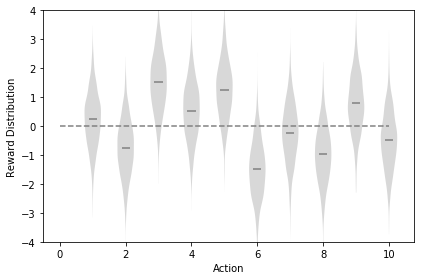

In [6]:
env = BanditEnv()

fig = plt.figure()
ax = fig.add_subplot(111)
parts = ax.violinplot(np.random.randn(2000,10) + env.means,
                      showmeans=True, showextrema=False)
for pc in parts['bodies']: pc.set_facecolor('gray')
parts['cmeans'].set_color('gray')
ax.plot([0,10],[0,0], color='gray', linestyle='--')
ax.set_ylim([-4, 4])
ax.set_xlabel("Action"); ax.set_ylabel("Reward Distribution")
plt.tight_layout()
plt.savefig('assets/fig_0201.png')
plt.show()

# Recreate Figure 2.2

Generate raw data, this may take a while

In [7]:
env = BanditEnv()

runs_ep0_A, runs_ep0_R = [], []      # eps=0, greedy
runs_ep01_A, runs_ep01_R = [], []    # eps=0.1
runs_ep001_A, runs_ep001_R = [], []  # eps=0.01

print('v' + ' '*18 + 'v')  # poor man tqdm
for i in range(2000):
    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0)
    _, runs_ep0_A.append(hist_A); runs_ep0_R.append(hist_R);
    
    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0.1)
    _, runs_ep01_A.append(hist_A); runs_ep01_R.append(hist_R); 
    
    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0.01)
    _, runs_ep001_A.append(hist_A); runs_ep001_R.append(hist_R);
    
    if i % 100 == 0: print('.', end='')
    
runs_ep0_A, runs_ep0_R = np.array(runs_ep0_A), np.array(runs_ep0_R)
runs_ep01_A, runs_ep01_R = np.array(runs_ep01_A), np.array(runs_ep01_R)
runs_ep001_A, runs_ep001_R = np.array(runs_ep001_A), np.array(runs_ep001_R)

v                  v
....................

Calc average reward and % optimal action

In [8]:
# Calc average reward
avg_ep0_R = np.average(runs_ep0_R, axis=0)
avg_ep01_R = np.average(runs_ep01_R, axis=0)
avg_ep001_R = np.average(runs_ep001_R, axis=0)

# Calc "% optimal action"
max_A = np.argmax(env.means)
opt_ep0_A = np.average(runs_ep0_A==max_A, axis=0)
opt_ep01_A = np.average(runs_ep01_A==max_A, axis=0)
opt_ep001_A = np.average(runs_ep001_A==max_A, axis=0)

Pretty plot

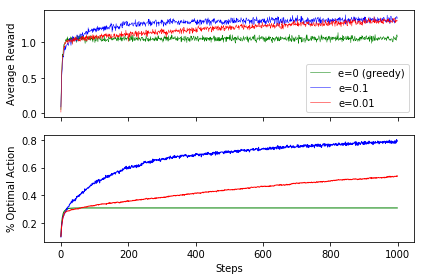

In [9]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(avg_ep0_R,   linewidth=0.5, color='green', label='e=0 (greedy)')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='e=0.1')
ax.plot(avg_ep001_R, linewidth=0.5, color='red',   label='e=0.01')
ax.set_ylabel('Average Reward')
ax.xaxis.set_ticklabels([])
ax.legend()

ax = fig.add_subplot(212)
ax.plot(opt_ep0_A,   linewidth=1., color='green', label='e=0 (greedy)')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='e=0.1')
ax.plot(opt_ep001_A, linewidth=1., color='red',   label='e=0.01')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')

plt.tight_layout()

plt.savefig('assets/fig_0202.png')
plt.show()

# Other Tests

Confirm Q-Values are estimated correctly

True:    [ 0.25 -0.75  1.5   0.5   1.25 -1.5  -0.25 -1.    0.75 -0.5 ]
Q:       [ 0.276 -0.719  1.503  0.52   1.231 -1.506 -0.266 -1.022  0.839 -0.46 ]
True - Q [-0.026 -0.031 -0.003 -0.02   0.019  0.006  0.016  0.022 -0.089 -0.04 ]


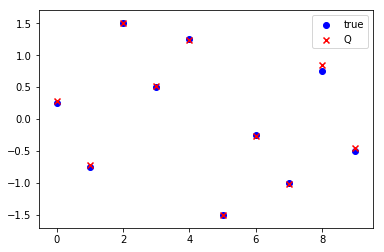

In [10]:
env = BanditEnv()

Q, _, _ = simple_bandit(env, nb=10000, eps=0.5)

print('True:   ', np.round(env.means, 3))
print('Q:      ', np.round(Q, 3))
print('True - Q', np.round(env.means-Q, 3))

plt.scatter(range(env.size), env.means, color='blue', marker='o', label='true')
plt.scatter(range(env.size), Q, color='red', marker='x', label='Q')
plt.legend();